<a href="https://colab.research.google.com/github/Joycechidi/Deep-Learning-/blob/master/CNN/Malaria_Cell_Detection_Using_VGGNet_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Transfer Learning
In this notebook, I'll be using VGGNet trained on the ImageNet dataset as a feature extractor. 

I'm using VGGNet because it's simple and has great performance, coming in second in the ImageNet competition. 

All the convolutional layers will be kept but I will replace the final fully-connected layer with my own classifier. This way I can use VGGNet as a fixed feature extractor for my images then easily train a simple classifier on top of that.

*   Use all but the last fully-connected layer as a fixed feature extractor.
*   Define a new, final classification layer and apply it to a task of our choice!

I am trying to use the dataset containing infected and uninfected malaria cell images. Downloaded from Kaggle here [https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria/download]

### Objective
Build a convolutional neural network that can detect the presence of malaria parasite in blood cells.

After training this dataset with VGGNet, I will also train with ResNet pre-trained model and then compare the performance between the two models.

In [12]:
!pip install jupyter_contrib_nbextensions

In [13]:
!jupyter contrib nbextension install --user

[I 02:31:01 InstallContribNbextensionsApp] jupyter contrib nbextension install --user
[I 02:31:01 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 02:31:02 InstallContribNbextensionsApp] Installing /usr/local/lib/python3.6/dist-packages/jupyter_contrib_nbextensions/nbextensions/freeze -> freeze
[I 02:31:02 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/freeze/icon.png
[I 02:31:02 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/freeze/main.js
[I 02:31:02 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/freeze/readme.md
[I 02:31:02 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/freeze/config.yaml
[I 02:31:02 InstallContribNbextensionsApp] - Validating: OK
[I 02:31:02 InstallContribNbextensionsApp] Installing /usr/local/lib/python3.6/dist-packages/jupyter_contrib_nbextensions/nbexte

In [0]:
%config IPCompleter.greedy=True

In [0]:
import os 
import numpy as np
import pandas as pd


import torch
import torchvision
from torchvision import datasets, models, transforms

import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

import matplotlib.pyplot as plt


%matplotlib inline

In [17]:
print(os.listdir("/content/gdrive/My Drive/Udacity_AI_Codes/DLND_Works/data/cell_images/cell_images/"))

['Uninfected', 'Parasitized', '.DS_Store']


In [19]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...') 

CUDA is available!  Training on GPU ...


## Loading the Data

In [0]:
# define training and test data directories
data_dir = os.path.join("/content/gdrive/My Drive/Udacity_AI_Codes/DLND_Works/data/cell_images/cell_images/")

# classes are folders in each directory with these names
classes = ['Uninfected', 'Parasitized']

## Transforming the Data

Since I am training this dataset with a pre-trained model, I will have to shape the input data into the shape the pre-trained model expects.

VGG16 expects 224-dim square images as input, so I'll resize each cell image to into this mold/shape.

### Data Augmentation


1.   Resized all images as input to 224 as expected by VGGNet
2.   Apply different transformation by rotating the images horizontally and vertically
3.   Convert images into PyTorch Tensors






In [0]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = {"train_transforms": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.ColorJitter(0.05),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomRotation(20),
                                      transforms.ToTensor()]),
                  "valid_transforms": transforms.Compose([transforms.Resize(224),
                                                         transforms.CenterCrop(224),
                                                         transforms.ToTensor()]),
                  "test_transforms": transforms.Compose([transforms.Resize(224),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor()])}

## Split the dataset

In [0]:
train_data = 0.8
valid_data = 0.1
test_data = 0.1

#Load the datasets with ImageFolder
train_data = datasets.ImageFolder(data_dir, transform=data_transform['train_transforms'])
valid_data = datasets.ImageFolder(data_dir, transform=data_transform['valid_transforms'])
test_data = datasets.ImageFolder(data_dir, transform=data_transform['test_transforms'])


### Obtain the training indices to be used for validation and testing

In [23]:
num_train = len(train_data)
indices = list(range(num_train))

train_count = int(0.8*num_train)
valid_count = int(0.1*num_train)
test_count = num_train - train_count - valid_count
train_idx = indices[:train_count]
valid_idx = indices[:train_count:train_count+valid_count]
test_idx= indices[train_count+valid_count:]


print(len(train_idx), len(valid_idx), len(test_idx))
print("Training", train_count, np.sum(len(train_idx)/num_train))
print("Validation", valid_count, np.sum(len(valid_idx)/num_train))
print("Test", test_count, np.sum(len(test_idx)/num_train))

22046 1 2757
Training 22046 0.7999854851585746
Validation 2755 3.628710356339357e-05
Test 2757 0.10004354452427608


In [0]:
 #Define a custom sampler for the dataset loader avoiding recreating the dataset (just creating a new loader for each different sampling)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

## **DataLoaders**

In [0]:
# Define dataloaders parameters
# Define the dataloaders using the image datasets
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 100, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 50, sampler = valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 50, sampler = test_sampler)

## **Data Visualization**



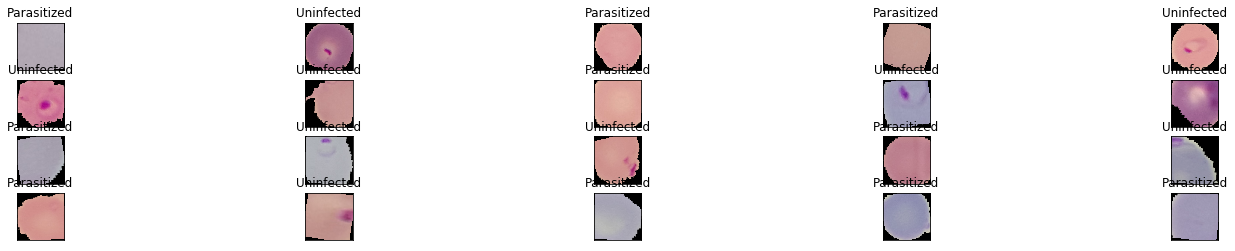

In [26]:
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Specify Model Architecture

Load the pre-trained model. This time, the VGGNet

To define a model for training I'll follow these steps:
1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor 
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

**Freezing simply means that the parameters in the pre-trained model will *not* change during training.**

In [27]:
# Loading the pretrained model from pytorch
#dir(torchvision.models)
vgg16 = models.vgg16(pretrained=True)

#print out the model structure
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 62.0MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Freeze all the features layers 

In [28]:
#You can access any layer in a pretrained network by name and (sometimes) number, 
#i.e. vgg16.classifier[6] is the sixth layer in a group of layers named "classifier"

print(vgg16.classifier[6].in_features)
print(vgg16.classifier[6].out_features)

# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

4096
1000


## Final Classifier Layer

Now that I have the pre-trained feature extractor, I just need to modify and add them to the final, fully-connected classifier layers.

Here, I am going to replace the last layer in the vgg classifier group of layers.


In [29]:
n_inputs = vgg16.classifier[6].in_features

#add last linear layer (n_inputs -> 2 cell image classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

if train_on_gpu:
    vgg16.cuda()
    
# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)

    

2


## Specify a Loss Function and Optimizer

(http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

I'll use cross-entropy loss and stochastic gradient descent with a small learning rate. The optimizer accepts as input _only_ the trainable parameters
'vgg.classifier.parameters'


In [0]:
import torch.optim as optim

#specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

#s specify optimizer (stochastic gradient descent) and learning rate
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

## Train the model

In [0]:
#number of training epochs for the model
n_epochs = 5

# Initialize tracker for minimum validation loss
valid_loss_min = np.inf

for epoch in range(1, n_epochs+1):
    # keep track of traing and validation losses
    train_loss = 0.0
    valid_loss = 0.0
    
    #################
    # train the model#
    #################
    #model by default is set to train
    vgg16.train()
    for batch_i, (data, target) in enumerate(trainloader):
        #move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
            
            
        #clear the gradients of all variables
        optimizer.zero_grad()
        #forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        #calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute  gradient of the loss with respect to the model parameters
        loss.backward()
        #perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()
        
        if batch_i % 20 == 19:
            #print training loss every specified number of mini-batches
            print("Epoch %d, Batch %d loss: %.16f" % (epoch, batch_i + 1, train_loss/20))
            train_loss = 0.0
            
    #Model evaluation
    vgg16.eval()
    for batch_idx, (data, target) in enumerate(validloader):
        #Move to GPU
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            # Update the average validation loss
            #Forward pass: compute predicted outputs by passing inputs to the model
            output = vgg16(data)
            #Calculate the batch loss
            loss = criterion(output, target)
            #Update the average validation loss
            valid_loss = valid_loss + ((1/ (batch_idx+1)) * (loss.data - valid_loss))
                
                
    # print training/validation progress
    print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
        epoch, train_loss,valid_loss))
                                                                           
    #Save the model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.5f} --> {:.5f}).Saving model ...'.format(
            valid_loss_min, vlid_loss))
        torch.save(vgg16.state_dict(), 'vgg16.pt')
        valid_loss_min = valid_loss 
                
#Define loaders transfer
loaders_transfer = {'train': trainloader,
                   'valid': validloader,
                   'test': testloader}


#Train the model
vgg16 = train(10, loaders_transfer, vgg16, optimizer, criterion, train_on_gpu, 'vgg.pt')
                  